# Road Features pro 500m-Grid (Köln)

- Grid mit Bar-Zonen laden
- OSM-Straßen pro Grid aggregieren (Länge, Shares, Counts)


In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns

### Grid laden

- 500m Grid mit Bar-Zonen
- CRS prüfen (metrisch)


In [ ]:
# Grid (500m) mit Bar-Zonen laden
grid_clean = gpd.read_parquet("grid_with_zones.parquet")
print(f"Grid geladen: {len(grid_clean)} Zellen")
print(f"Spalten: {grid_clean.columns.tolist()}")


Grid geladen: 1770 Zellen
Spalten: ['geometry', 'GridID', 'bar_count', 'ZoneType_4', 'Acc_total', 'Acc_EN', 'Acc_day', 'Acc_severe', 'Delta_ENvsDay']


### Straßen laden

- OSM Edges mit Attributen
- CRS an Grid anpassen


In [ ]:
# OSM-Straßensegmente (Edges) laden
streets = gpd.read_parquet("edges_features.parquet")
print(f"Streets geladen: {len(streets)} Segmente")
print(f"Spalten: {streets.columns.tolist()}")


Streets geladen: 36250 Segmente
Spalten: ['highway', 'oneway', 'reversed', 'length', 'geometry', 'has_signal', 'has_crossing', 'has_sidewalk', 'has_parking', 'lanes_clean', 'maxspeed_clean', 'lanes_imputed', 'maxspeed_imputed']


### Intersection

- Segmente auf Grid schneiden
- Längen nach Clip verwenden


In [ ]:
# Straßensegmente auf Grid-Zellen zuschneiden (Intersection)
streets_clipped = gpd.overlay(
    streets[['highway', 'maxspeed_imputed', 'lanes_imputed',
             'oneway', 'has_signal', 'has_crossing', 'has_sidewalk', 'has_parking',
             'length', 'geometry']],
    grid_clean[['GridID', 'geometry']],
    how='intersection'
)

streets_clipped['length_clipped'] = streets_clipped.geometry.length

print(f"streets_clipped: {len(streets_clipped)} Segmente")
print(f"Spalten: {streets_clipped.columns.tolist()}")


streets_clipped: 46835 Segmente
Spalten: ['highway', 'maxspeed_imputed', 'lanes_imputed', 'oneway', 'has_signal', 'has_crossing', 'has_sidewalk', 'has_parking', 'length', 'GridID', 'geometry', 'length_clipped']


### Exposure Features

- road_km pro Grid
- Segmente pro km


In [ ]:
# Straßenlänge pro Grid (km)
road_km_per_grid = streets_clipped.groupby('GridID')['length_clipped'].sum().reset_index()
road_km_per_grid['road_km'] = road_km_per_grid['length_clipped'] / 1000
road_km_per_grid = road_km_per_grid[['GridID', 'road_km']]

grid_clean = grid_clean.merge(road_km_per_grid, on='GridID', how='left')
grid_clean['road_km'] = grid_clean['road_km'].fillna(0)

print(f"road_km Statistik:")
print(grid_clean['road_km'].describe())


road_km Statistik:
count    1770.000000
mean        2.442470
std         2.298500
min         0.000000
25%         0.000000
50%         1.927873
75%         4.357936
max         8.505882
Name: road_km, dtype: float64


In [ ]:
# Segment-Anzahl pro Grid + Dichte (pro road_km)
segments_per_grid = streets_clipped.groupby('GridID').size().reset_index(name='segments_count')
grid_clean = grid_clean.merge(segments_per_grid, on='GridID', how='left')
grid_clean['segments_count'] = grid_clean['segments_count'].fillna(0).astype(int)

# safe division (road_km kann 0 sein)
grid_clean['segments_per_roadkm'] = np.where(
    grid_clean['road_km'] > 0,
    grid_clean['segments_count'] / grid_clean['road_km'],
    0
)

print(f"segments_count: {grid_clean['segments_count'].describe()}")


segments_count: count    1770.000000
mean       26.460452
std        30.340369
min         0.000000
25%         0.000000
50%        14.000000
75%        45.000000
max       144.000000
Name: segments_count, dtype: float64


### Lage-Feature

- dist_center (Zentrum-Proxy)


In [ ]:
# Distanz zum Stadtzentrum (Proxy: Köln Mitte)
koeln_center = Point(356900, 5645400)

grid_clean['dist_center'] = grid_clean.geometry.centroid.distance(koeln_center)

print(f"dist_center Statistik:")
print(grid_clean['dist_center'].describe())


dist_center Statistik:
count     1770.000000
mean      8588.058443
std       3694.323907
min        259.027000
25%       5923.764767
50%       8499.699005
75%      10946.982956
max      18825.281503
Name: dist_center, dtype: float64


### Highway Klassen

- major vs residential
- Längen pro Grid vorbereiten


In [ ]:
# Highway-Typen als einfache Klassen (major/residential)
streets_clipped['is_major'] = streets_clipped['highway'].isin(['primary', 'secondary', 'tertiary']).astype(int)
streets_clipped['is_residential'] = (streets_clipped['highway'] == 'residential').astype(int)
streets_clipped['is_speed_over50'] = (streets_clipped['maxspeed_imputed'] > 50).astype(int)
streets_clipped['is_lanes_ge2'] = (streets_clipped['lanes_imputed'] >= 2).astype(int)

streets_clipped['speed_x_length'] = streets_clipped['maxspeed_imputed'] * streets_clipped['length_clipped']
streets_clipped['lanes_x_length'] = streets_clipped['lanes_imputed'] * streets_clipped['length_clipped']

streets_clipped['major_length'] = streets_clipped['is_major'] * streets_clipped['length_clipped']
streets_clipped['residential_length'] = streets_clipped['is_residential'] * streets_clipped['length_clipped']
streets_clipped['speed_over50_length'] = streets_clipped['is_speed_over50'] * streets_clipped['length_clipped']
streets_clipped['lanes_ge2_length'] = streets_clipped['is_lanes_ge2'] * streets_clipped['length_clipped']


### Anteile & gewichtete Mittelwerte

- Straßenanteile (major/residential)
- maxspeed / lanes (längen-gewichtet)


In [ ]:
# Längen-gewichtete Highway/Speed/Lanes Features pro Grid
street_features = streets_clipped.groupby('GridID').agg(
    total_length=('length_clipped', 'sum'),
    major_length=('major_length', 'sum'),
    residential_length=('residential_length', 'sum'),
    speed_x_length=('speed_x_length', 'sum'),
    speed_over50_length=('speed_over50_length', 'sum'),
    lanes_x_length=('lanes_x_length', 'sum'),
    lanes_ge2_length=('lanes_ge2_length', 'sum')
).reset_index()

# safe divisions (total_length kann 0 sein)
total = street_features['total_length'].to_numpy()

street_features['major_road_km_share'] = np.divide(
    street_features['major_length'].to_numpy(), total,
    out=np.zeros_like(total, dtype=float),
    where=total > 0
)
street_features['residential_km_share'] = np.divide(
    street_features['residential_length'].to_numpy(), total,
    out=np.zeros_like(total, dtype=float),
    where=total > 0
)
street_features['maxspeed_mean_weighted'] = np.divide(
    street_features['speed_x_length'].to_numpy(), total,
    out=np.zeros_like(total, dtype=float),
    where=total > 0
)
street_features['maxspeed_share_over50'] = np.divide(
    street_features['speed_over50_length'].to_numpy(), total,
    out=np.zeros_like(total, dtype=float),
    where=total > 0
)
street_features['lanes_mean_weighted'] = np.divide(
    street_features['lanes_x_length'].to_numpy(), total,
    out=np.zeros_like(total, dtype=float),
    where=total > 0
)
street_features['lanes_share_ge2'] = np.divide(
    street_features['lanes_ge2_length'].to_numpy(), total,
    out=np.zeros_like(total, dtype=float),
    where=total > 0
)

street_features = street_features[['GridID', 'major_road_km_share', 'residential_km_share',
                                   'maxspeed_mean_weighted', 'maxspeed_share_over50',
                                   'lanes_mean_weighted', 'lanes_share_ge2']]

grid_clean = grid_clean.merge(street_features, on='GridID', how='left')
for col in ['major_road_km_share', 'residential_km_share', 'maxspeed_mean_weighted',
            'maxspeed_share_over50', 'lanes_mean_weighted', 'lanes_share_ge2']:
    grid_clean[col] = grid_clean[col].fillna(0)

print("Highway/Speed/Lanes Features hinzugefügt")


Highway/Speed/Lanes Features hinzugefügt


### Infrastruktur-Counts & Shares

- signals / crossings pro km
- oneway / sidewalk / parking shares


In [ ]:
# Konflikt-/Infrastruktur-Features pro Grid (Signals, Crossings, Oneway/Sidewalk/Parking Shares)
streets_clipped['oneway_length'] = streets_clipped['oneway'] * streets_clipped['length_clipped']
streets_clipped['sidewalk_length'] = streets_clipped['has_sidewalk'] * streets_clipped['length_clipped']
streets_clipped['parking_length'] = streets_clipped['has_parking'] * streets_clipped['length_clipped']

conflict_features = streets_clipped.groupby('GridID').agg(
    signal_count=('has_signal', 'sum'),
    crossing_count=('has_crossing', 'sum'),
    oneway_length=('oneway_length', 'sum'),
    sidewalk_length=('sidewalk_length', 'sum'),
    parking_length=('parking_length', 'sum'),
    total_length=('length_clipped', 'sum')
).reset_index()

total = conflict_features['total_length'].to_numpy()
km = total / 1000.0

conflict_features['oneway_km_share'] = np.divide(
    conflict_features['oneway_length'].to_numpy(), total,
    out=np.zeros_like(total, dtype=float),
    where=total > 0
)
conflict_features['sidewalk_km_share'] = np.divide(
    conflict_features['sidewalk_length'].to_numpy(), total,
    out=np.zeros_like(total, dtype=float),
    where=total > 0
)
conflict_features['parking_km_share'] = np.divide(
    conflict_features['parking_length'].to_numpy(), total,
    out=np.zeros_like(total, dtype=float),
    where=total > 0
)

# Counts pro road_km (km kann 0 sein)
conflict_features['signals_per_roadkm'] = np.divide(
    conflict_features['signal_count'].to_numpy(), km,
    out=np.zeros_like(km, dtype=float),
    where=km > 0
)
conflict_features['crossings_per_roadkm'] = np.divide(
    conflict_features['crossing_count'].to_numpy(), km,
    out=np.zeros_like(km, dtype=float),
    where=km > 0
)

conflict_features = conflict_features[['GridID', 'signals_per_roadkm', 'crossings_per_roadkm',
                                       'oneway_km_share', 'sidewalk_km_share', 'parking_km_share']]

grid_clean = grid_clean.merge(conflict_features, on='GridID', how='left')
for col in ['signals_per_roadkm', 'crossings_per_roadkm', 'oneway_km_share',
            'sidewalk_km_share', 'parking_km_share']:
    grid_clean[col] = grid_clean[col].fillna(0)

print("Konfliktpunkt-Features hinzugefügt")


Konfliktpunkt-Features hinzugefügt


### Merge & Checks

- Features ins Grid mergen
- Missing / Zero-road Check


In [ ]:
print("Features")
print(f"Shape: {grid_clean.shape}")
print(f"\nSpalten:")
for col in grid_clean.columns:
    print(f"  {col}: {grid_clean[col].dtype}")

Features
Shape: (1770, 24)

Spalten:
  geometry: geometry
  GridID: int64
  bar_count: int64
  ZoneType_4: category
  Acc_total: float64
  Acc_EN: float64
  Acc_day: float64
  Acc_severe: float64
  Delta_ENvsDay: float64
  road_km: float64
  segments_count: int64
  segments_per_roadkm: float64
  dist_center: float64
  major_road_km_share: float64
  residential_km_share: float64
  maxspeed_mean_weighted: float64
  maxspeed_share_over50: float64
  lanes_mean_weighted: float64
  lanes_share_ge2: float64
  signals_per_roadkm: float64
  crossings_per_roadkm: float64
  oneway_km_share: float64
  sidewalk_km_share: float64
  parking_km_share: float64


In [ ]:
model_features = [
    'bar_count',
    'road_km',
    'segments_count',
    'segments_per_roadkm',
    'dist_center',
    'major_road_km_share',
    'residential_km_share',
    'maxspeed_mean_weighted',
    'maxspeed_share_over50',
    'lanes_mean_weighted',
    'lanes_share_ge2',
    'signals_per_roadkm',
    'crossings_per_roadkm',
    'oneway_km_share',
    'sidewalk_km_share',
    'parking_km_share'
]

print(f"Model Features: {len(model_features)}")
print(grid_clean[model_features].describe().T.round(2))

Model Features: 16
                         count     mean      std     min      25%      50%  \
bar_count               1770.0     0.88     3.87    0.00     0.00     0.00   
road_km                 1770.0     2.44     2.30    0.00     0.00     1.93   
segments_count          1770.0    26.46    30.34    0.00     0.00    14.00   
segments_per_roadkm     1770.0     8.17    13.13    0.00     0.00     7.80   
dist_center             1770.0  8588.06  3694.32  259.03  5923.76  8499.70   
major_road_km_share     1770.0     0.25     0.30    0.00     0.00     0.15   
residential_km_share    1770.0     0.32     0.34    0.00     0.00     0.20   
maxspeed_mean_weighted  1770.0    35.18    26.89    0.00     0.00    35.10   
maxspeed_share_over50   1770.0     0.15     0.29    0.00     0.00     0.00   
lanes_mean_weighted     1770.0     1.36     1.04    0.00     0.00     1.39   
lanes_share_ge2         1770.0     0.36     0.36    0.00     0.00     0.29   
signals_per_roadkm      1770.0     1.39     2

In [ ]:
print("\nMissing Values:")
missing = grid_clean[model_features].isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "Keine Missing Values")


Missing Values:
Keine Missing Values


In [ ]:
zero_road = (grid_clean['road_km'] == 0).sum()
print(f"\nGrids ohne Straßen (road_km=0): {zero_road} ({zero_road/len(grid_clean)*100:.1f}%)")

problem_grids = grid_clean[(grid_clean['road_km'] == 0) & (grid_clean['Acc_EN'] > 0)]
print(f"Grids mit road_km=0 aber Unfällen: {len(problem_grids)}")
if len(problem_grids) > 0:
    print(problem_grids[['GridID', 'Acc_EN', 'road_km', 'bar_count']].head(10))


Grids ohne Straßen (road_km=0): 446 (25.2%)
Grids mit road_km=0 aber Unfällen: 14
      GridID  Acc_EN  road_km  bar_count
61        61     1.0      0.0          0
81        81     1.0      0.0          0
117      117     5.0      0.0          0
198      198     1.0      0.0          0
614      614     1.0      0.0          0
1225    1225     1.0      0.0          0
1611    1611     1.0      0.0          0
1639    1639     1.0      0.0          0
1679    1679     1.0      0.0          0
1697    1697     3.0      0.0          0


### ZoneType Auswertung

- Summen & Raten pro ZoneType
- Quick Plots


In [ ]:
# Metriken pro ZoneType (Summen + einfache Raten)
metrics_table = grid_clean.groupby('ZoneType_4', observed=True).agg(
    N_Grids=('GridID', 'size'),
    Total_road_km=('road_km', 'sum'),
    Total_Acc=('Acc_total', 'sum'),
    Total_Acc_EN=('Acc_EN', 'sum'),
    Total_Acc_severe=('Acc_severe', 'sum')
).reset_index()

# safe divisions (Totals können 0 sein)
metrics_table['Share_EN'] = np.divide(
    metrics_table['Total_Acc_EN'], metrics_table['Total_Acc'],
    out=np.zeros_like(metrics_table['Total_Acc_EN'], dtype=float),
    where=metrics_table['Total_Acc'] > 0
)
metrics_table['Acc_EN_per_roadkm'] = np.divide(
    metrics_table['Total_Acc_EN'], metrics_table['Total_road_km'],
    out=np.zeros_like(metrics_table['Total_Acc_EN'], dtype=float),
    where=metrics_table['Total_road_km'] > 0
)
metrics_table['Acc_severe_per_roadkm'] = np.divide(
    metrics_table['Total_Acc_severe'], metrics_table['Total_road_km'],
    out=np.zeros_like(metrics_table['Total_Acc_severe'], dtype=float),
    where=metrics_table['Total_road_km'] > 0
)

print(metrics_table)



Metriken nach ZoneType:
  ZoneType_4  N_Grids  Total_road_km  Total_Acc  Total_Acc_EN  \
0     Barlos     1365       2491.241     4885.0        1556.0   
1     Bararm      276       1183.340     3100.0        1022.0   
2    Barzone       95        457.404     2436.0         879.0   
3    Hotspot       34        191.187     2038.0         884.0   

   Total_Acc_severe  Share_EN  Acc_EN_per_roadkm  Acc_total_per_roadkm  
0             871.0     0.319              0.625                 1.961  
1             502.0     0.330              0.864                 2.620  
2             343.0     0.361              1.922                 5.326  
3             259.0     0.434              4.624                10.660  


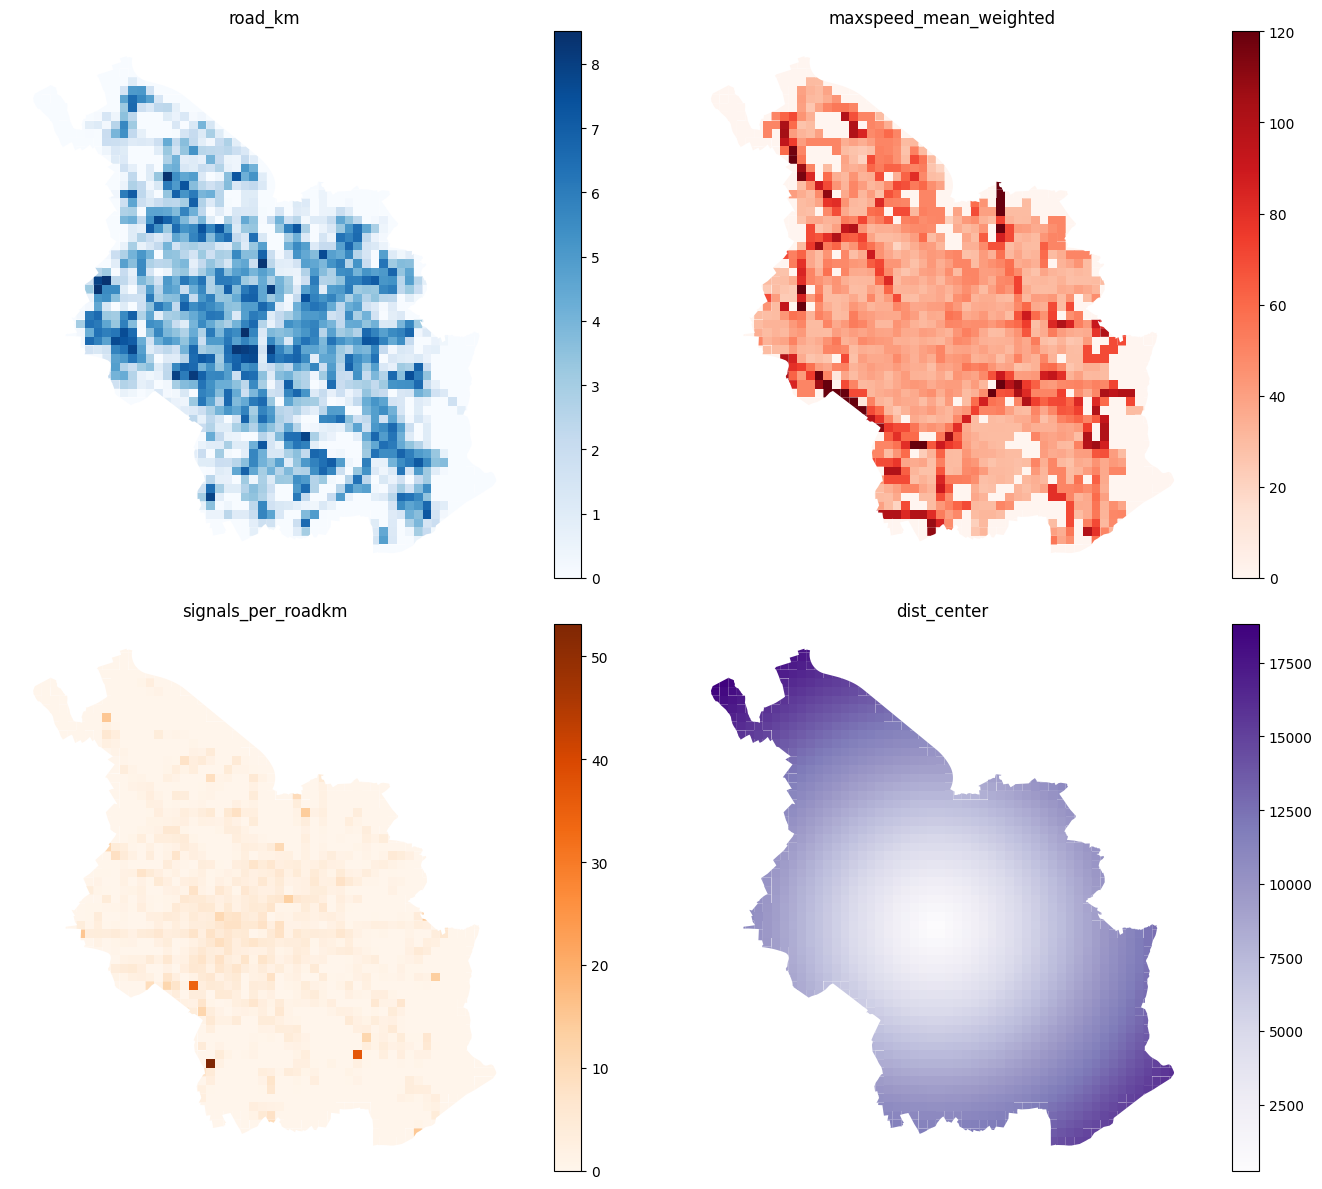

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

grid_clean.plot(column='road_km', ax=axes[0, 0], legend=True, cmap='Blues')
axes[0, 0].set_title('road_km')
axes[0, 0].set_axis_off()

grid_clean.plot(column='maxspeed_mean_weighted', ax=axes[0, 1], legend=True, cmap='Reds')
axes[0, 1].set_title('maxspeed_mean_weighted')
axes[0, 1].set_axis_off()

grid_clean.plot(column='signals_per_roadkm', ax=axes[1, 0], legend=True, cmap='Oranges')
axes[1, 0].set_title('signals_per_roadkm')
axes[1, 0].set_axis_off()

grid_clean.plot(column='dist_center', ax=axes[1, 1], legend=True, cmap='Purples')
axes[1, 1].set_title('dist_center')
axes[1, 1].set_axis_off()

plt.tight_layout()
plt.show()

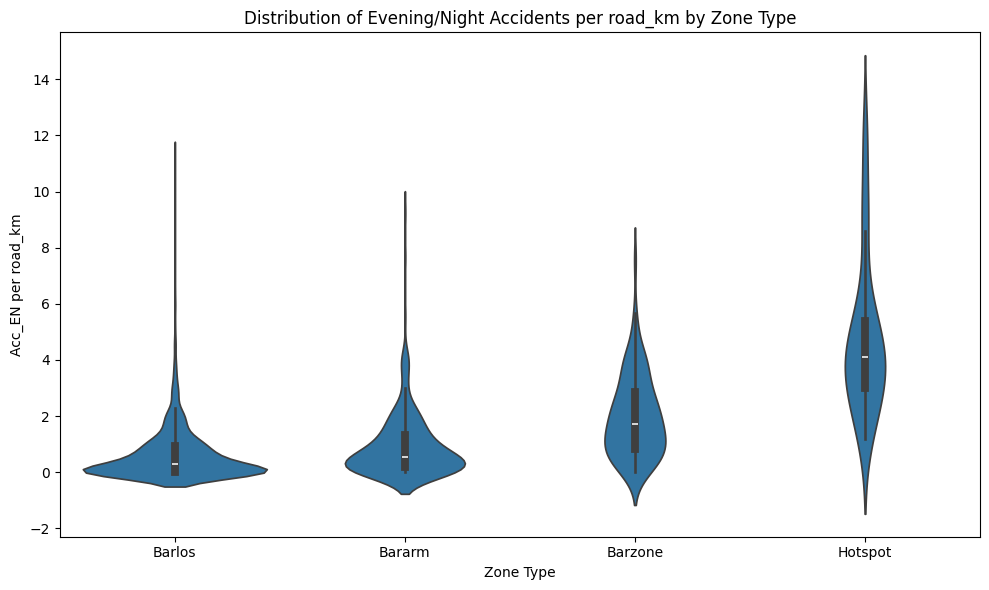

In [ ]:
# Quick sanity plot: Acc_EN pro road_km nach ZoneType (nur Grids mit road_km>0)
grid_with_roads = grid_clean[grid_clean['road_km'] > 0].copy()
grid_with_roads['Acc_EN_per_roadkm'] = grid_with_roads['Acc_EN'] / grid_with_roads['road_km']

fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(
    data=grid_with_roads,
    x='ZoneType_4',
    y='Acc_EN_per_roadkm',
    order=['Barlos', 'Bararm', 'Barzone', 'Hotspot'],
    ax=ax
)
ax.set_ylabel('Acc_EN per road_km')
ax.set_xlabel('Zone Type')
ax.set_title('Distribution of Evening/Night Accidents per road_km by Zone Type')
plt.tight_layout()
plt.show()


In [ ]:
sample_barlos = grid_clean[grid_clean['ZoneType_4'] == 'Barlos'].head(1)
sample_hotspot = grid_clean[grid_clean['ZoneType_4'] == 'Hotspot'].head(1)
sample_df = pd.concat([sample_barlos, sample_hotspot])

display_cols = ['GridID', 'ZoneType_4', 'road_km', 'bar_count', 'dist_center',
                'major_road_km_share', 'maxspeed_mean_weighted', 'signals_per_roadkm']
print("\nSample: Barlos vs Hotspot")
print(sample_df[display_cols].to_string(index=False))


Sample: Barlos vs Hotspot
 GridID ZoneType_4  road_km  bar_count  dist_center  major_road_km_share  maxspeed_mean_weighted  signals_per_roadkm
      0     Barlos 0.000000          0 18277.353451             0.000000                0.000000            0.000000
    489    Hotspot 4.371636         11  3896.261892             0.524211               40.552697            3.888705


### Export

- grid_features.parquet schreiben


In [ ]:
# Export: Grid + Bar-Zonen + Road-Features
output_path = "grid_features.parquet"
grid_clean.to_parquet(output_path)

print(f"Gespeichert: {output_path} ({len(grid_clean)} Grids)")



Gespeichert: grid_features.parquet
Shape: (1770, 24)
